# Mar ??, 2022 (overlap size: net & node)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_dir = pjoin(tmp_dir, 'fig_paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

BOLD   : : :   ovp: 0.9943,  disj: 0.9816

Ca2    : : :   ovp: 0.9874,  disj: 0.9494

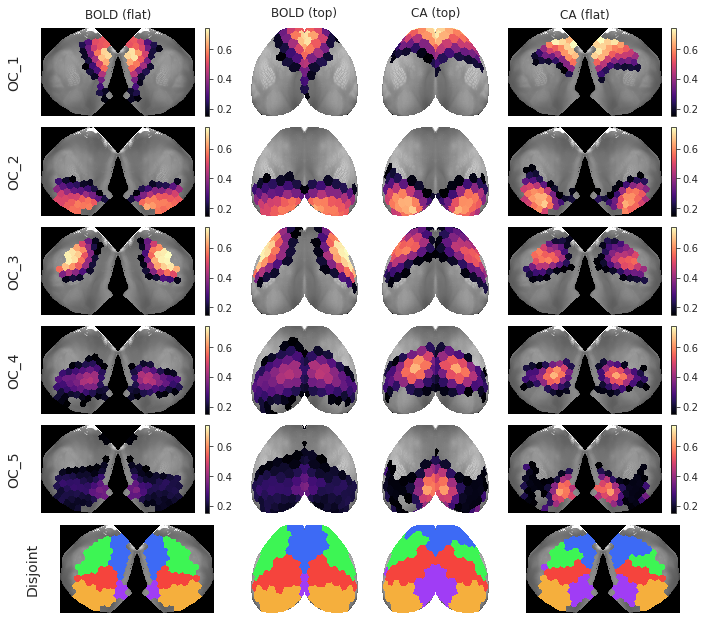

In [5]:
proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ovp, disj = gr_bold.pi_symmetry_score(decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bold,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    min_thres=0.15,
)

## New proportions fig

In [6]:
i, j, k = gr_bold.run_cut_prune.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}


b_grp_bold = bootstrap(
    x=gr_bold.run_cut_prune,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
b_grp_bold = bn.nanmean(bn.nanmean(bn.nanmean(b_grp_bold, 3), 2), 1)
se_boot = bn.nanstd(b_grp_bold, 0, ddof=1)
df_bold = gr_bold.mk_boot_df(se_boot, gr_bold.anim_cut_prune)


b_grp_ca = bootstrap(
    x=gr_ca.run_cut_prune,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
b_grp_ca = bn.nanmean(bn.nanmean(bn.nanmean(b_grp_ca, 3), 2), 1)
se_boot = bn.nanstd(b_grp_ca, 0, ddof=1)
df_ca = gr_ca.mk_boot_df(se_boot, gr_ca.anim_cut_prune)

In [7]:
mice.cfg.ll = 3

pi_srf = gr_ca.get_surface_pi(gr_ca.grp_pi)
proj = gr_ca.project_vec(pi_srf, layer=0, add_disjoint=False)
tr_ca = gr_ca.trim2d(proj)

pi_srf = gr_bold.get_surface_pi(gr_bold.grp_pi)
proj = gr_bold.project_vec(pi_srf, layer=0, add_disjoint=False)
tr_bold = gr_bold.trim2d(proj)

In [76]:
fig, axes, axes_inset = plot_proportions(df_ca, df_bold, figsize_x=15, figsize_y=6.1)
for oc, ax in enumerate(axes[0], start=1):
    ax.set_title(f'OC-{oc}', fontsize=20, y=1.03)
name = f'props'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')


fig, axes, axes_inset = plot_proportions(
    df_ca=df_ca,
    df_bold=df_bold,
    inset_ca=tr_ca,
    inset_bold=tr_bold,
    figsize_y=6.1,
    figsize_x=15,
)
for oc, ax in enumerate(axes[0], start=1):
    ax.set_title(f'OC-{oc}', fontsize=20, y=1.03)
name = f'props-inset'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

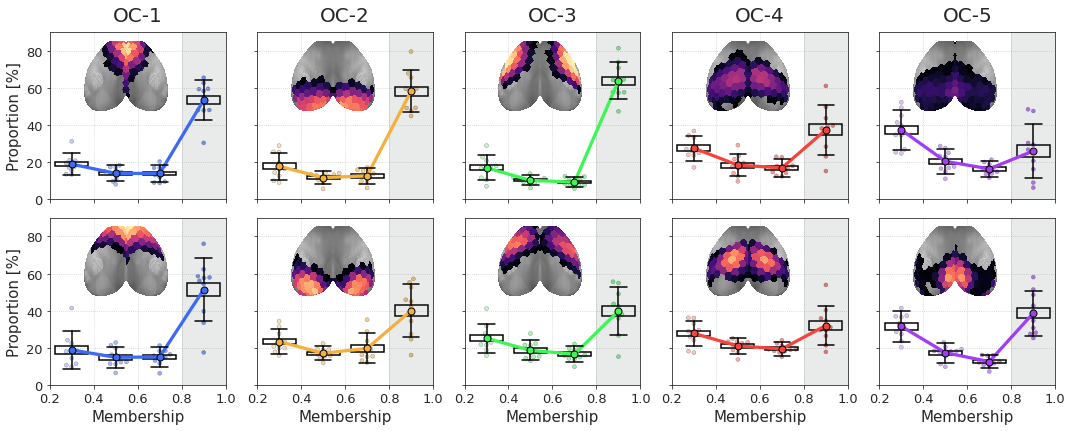

In [77]:
fig

In [78]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}

In [79]:
vmin, vmax = 0.15, 0.75
for i in range(5):

    fig, ax = create_figure(figsize=(1.5, 1))
    x2p = mwh(tr_bold['top'] == 0, tr_ca['top'])
    ax.imshow(x2p, cmap='Greys_r')
    x2p = mwh(tr_bold['proj-top'][i] < 0.15, tr_bold['proj-top'][i])
    ax.imshow(x2p, cmap='magma', vmin=vmin, vmax=vmax)
    remove_ticks(ax)

    name = f'OC-{i+1}_bold'
    # figname = f"{name}.pdf"
    # fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
    for dpi in [1000]:
        figname = f"{name}_dpi{dpi}.png"
        fig.savefig(pjoin(fig_dir, figname), dpi=dpi, **fig_kws)
    plt.close()


    fig, ax = create_figure(figsize=(1.5, 1))
    x2p = mwh(tr_ca['top'] == 0, tr_ca['top'])
    ax.imshow(x2p, cmap='Greys_r')
    x2p = mwh(tr_ca['proj-top'][i] < 0.15, tr_ca['proj-top'][i])
    ax.imshow(x2p, cmap='magma', vmin=vmin, vmax=vmax)
    remove_ticks(ax)

    name = f'OC-{i+1}_ca'
    # figname = f"{name}.pdf"
    # fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
    for dpi in [1000]:
        figname = f"{name}_dpi{dpi}.png"
        fig.savefig(pjoin(fig_dir, figname), dpi=dpi, **fig_kws)
    plt.close()

In [10]:
fig, axes, axes_inset = plot_proportions(
    df_ca=df_ca,
    df_bold=df_bold,
    inset_ca=tr_ca,
    inset_bold=tr_bold,
    horizontal=False,
    figsize_x=13,
    figsize_y=6,
)
name = f'props-vert'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

## Count num ovp per comm

In [14]:
i, j, k = 7, 0, 0
x = gr_ca.run_pi_prune[i, j, k] > 0.2
ovp_nodes = x.sum(0) > 1

In [15]:
portion_ovp = (ovp_nodes * x).sum(1) / x.sum(1)
portion_ovp

array([0.5952381 , 0.4893617 , 0.60606061, 0.63461538, 0.43902439])

In [16]:
x = gr_ca.run_pi_prune > 0.2
ovp_nodes = x.sum(-2, keepdims=True) > 1
portion_ovp = (ovp_nodes * x).sum(-1) / x.sum(-1)
portion_ovp_avg = bn.nanmean(bn.nanmean(bn.nanmean(portion_ovp, 2), 1), 0)

portion_ovp.shape, portion_ovp_avg.shape

((10, 3, 4, 5), (5,))

In [17]:
portion_ovp[i, j, k]

array([0.5952381 , 0.4893617 , 0.60606061, 0.63461538, 0.43902439])

In [18]:
portion_ovp_avg

array([0.44172266, 0.51655197, 0.56084204, 0.63401297, 0.57507811])

In [19]:
x = gr_bold.run_pi_prune > 0.2
ovp_nodes = x.sum(-2, keepdims=True) > 1
portion_ovp = (ovp_nodes * x).sum(-1) / x.sum(-1)
portion_ovp_avg = bn.nanmean(bn.nanmean(bn.nanmean(portion_ovp, 2), 1), 0)

portion_ovp_avg

array([0.42189855, 0.39807471, 0.34358818, 0.5851225 , 0.69344499])

### Detect overlapping nodes

In [20]:
x = gr_ca.run_pi_prune > 0.2
ovp_nodes = x.sum(-2, keepdims=True) > 1
ovp_nodes = ovp_nodes * x
ovp_nodes_avg = ovp_nodes.mean(2).mean(1).mean(0)

ovp_nodes.shape, ovp_nodes_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [21]:
proj = gr_ca.project_vec(ovp_nodes_avg, layer=0, add_disjoint=False)
tr = gr_ca.trim2d(proj)

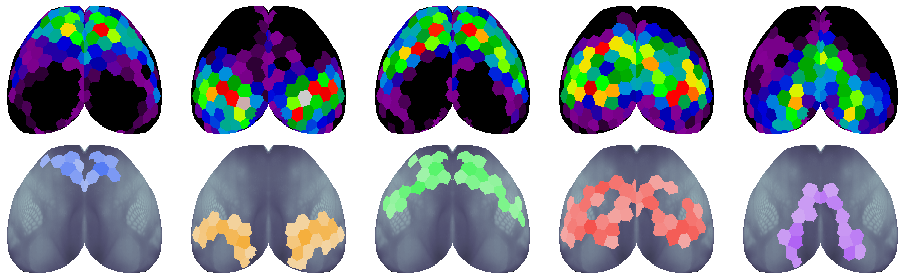

In [22]:
fig, axes = create_figure(2, 5, (13, 4))

x2p = mwh(tr['top'] == 0, tr['top'])
for ax in axes.flat:
    ax.imshow(x2p, cmap='bone')
for k in range(5):
    ax = axes[0, k]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][k])
    ax.imshow(x2p, cmap='nipy_spectral', vmin=0, vmax=0.725)
    
    ax = axes[1, k]
    x2p = mwh(tr['proj-top'][k] < 0.3, tr['proj-top'][k])
    
    cmap = gr_ca.cmaps[k + 1]# 'YlOrRd_r'
    ax.imshow(x2p, cmap=cmap, vmin=0, vmax=0.725)
    
remove_ticks(axes)

In [23]:
x = gr_ca.anim_pi_prune > 0.2
ovp_nodes = x.sum(-2, keepdims=True) > 1
ovp_nodes = ovp_nodes * x
ovp_nodes_avg = ovp_nodes.mean(0)

ovp_nodes.shape, ovp_nodes_avg.shape

((10, 5, 174), (5, 174))

In [24]:
proj = gr_ca.project_vec(ovp_nodes_avg, layer=0, add_disjoint=False)
tr = gr_ca.trim2d(proj)

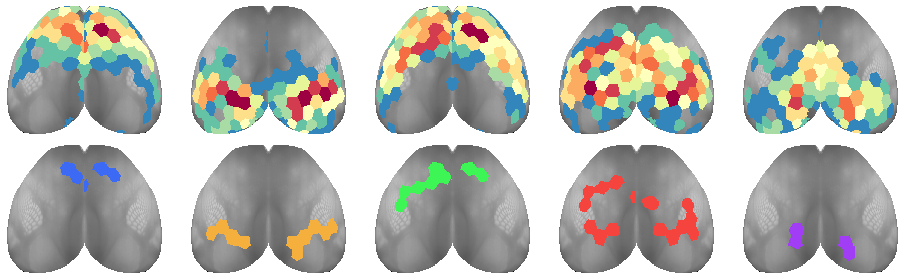

In [25]:
fig, axes = create_figure(2, 5, (13, 4))

x2p = mwh(tr['top'] == 0, tr['top'])
for ax in axes.flat:
    ax.imshow(x2p, cmap='Greys_r')
for k in range(5):
    ax = axes[0, k]
    x2p = mwh(tr['proj-top'][k] < 0.1, tr['proj-top'][k])
    ax.imshow(x2p, cmap='Spectral_r', vmin=0, vmax=1)
    
    ax = axes[1, k]
    x2p = tr['proj-top'][k] > 0.7
    x2p = mwh(~x2p, x2p)
    
    cmap = gr_ca.cmaps[k + 1]# 'YlOrRd_r'
    ax.imshow(x2p, cmap=cmap, vmin=0)
    
remove_ticks(axes)

## Pacman figure

In [99]:
thres = 0.2

In [100]:
x = gr_ca.run_pi_prune > thres
ovp_nodes = x.sum(-2, keepdims=True) > 1
portion_ovp_ca = (ovp_nodes * x).sum(-1) / x.sum(-1) * 100
portion_ovp_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(portion_ovp_ca, 2), 1), 0)

x = gr_bold.run_pi_prune > thres
ovp_nodes = x.sum(-2, keepdims=True) > 1
portion_ovp_bold = (ovp_nodes * x).sum(-1) / x.sum(-1) * 100
portion_ovp_bold_avg = bn.nanmean(bn.nanmean(bn.nanmean(portion_ovp_bold, 2), 1), 0)

In [101]:
portion_ovp_ca_avg, portion_ovp_bold_avg

(
    array([44.17226617, 51.65519665, 56.08420407, 63.40129688, 57.50781136]),
    array([42.1898547 , 39.80747099, 34.3588183 , 58.51224957, 69.34449917])
)

In [102]:
i, j, k = portion_ovp_bold.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

boot = bootstrap(
    x=portion_ovp_bold,
    n_resamples=int(1e5),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_bold = bn.nanstd(boot, 0, ddof=1)

boot = bootstrap(
    x=portion_ovp_ca,
    n_resamples=int(1e5),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

se_bold, se_ca

(
    array([2.75978431, 3.21204618, 2.79657918, 3.80576814, 3.9218194 ]),
    array([4.55630126, 3.07430441, 3.50130146, 2.93460169, 3.42400255])
)

In [103]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)

e_bold, e_ca = se_bold * t, se_ca * t
e_bold, e_ca

(
    array([6.24306585, 7.26615327, 6.32630163, 8.60924566, 8.87177186]),
    array([10.30706953,  6.95455975,  7.92049418,  6.63853023,  7.74563189])
)

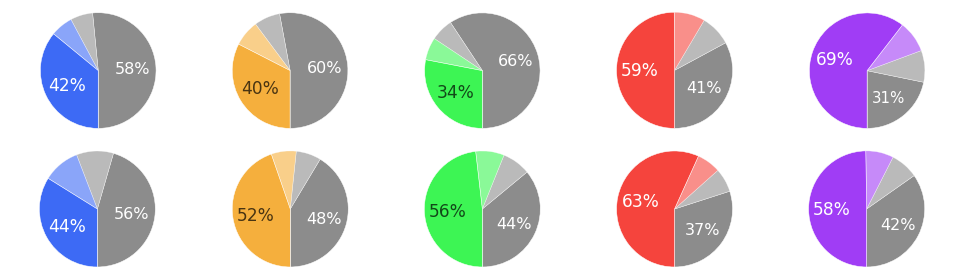

In [104]:
grey = list(sns.color_palette('deep'))[-3]
fig, axes = create_figure(2, 5, (13.5, 4))

for k in range(5):
    ax = axes[0, k]
    x = [100 - portion_ovp_bold_avg[k] - e_bold[k], e_bold[k], e_bold[k], portion_ovp_bold_avg[k] - e_bold[k]]
    patches, _, autotexts = ax.pie(
        x=x,
        # labels=['Disjoint', 'Mixed'],
        explode=(0,) * len(x),
        autopct='%1.0f%%',
        shadow=False,
        startangle=270,
        labeldistance=1.2,
        colors=[grey] * 2 + [gr_bold.colors[k + 1]] * 2,
        wedgeprops = {'linewidth': 0.5},
        textprops={'fontsize': 16},
    )
    for i, t in enumerate(autotexts):
        t.set_color('white')
        if i == 0:
            t.set_text(f"{sum(x[:2]):0.0f}%")
            if k == 4:
                t.set_fontsize(15)
        elif i in [1, 2]:
            t.set_text('')
            patches[i].set_alpha(0.6)
        else:
            t.set_text(f"{sum(x[2:]):0.0f}%")
            t.set_fontsize(17)
            if k in [1, 2]:
                t.set_color('k')
                t.set_alpha(0.7)
    ax.axis('equal')
    
    ax = axes[1, k]
    x = [100 - portion_ovp_ca_avg[k] - e_ca[k], e_ca[k], e_ca[k], portion_ovp_ca_avg[k] - e_ca[k]]
    patches, _, autotexts = ax.pie(
        x=x,
        # labels=['Disjoint', 'Mixed'],
        explode=(0,) * len(x),
        autopct='%1.0f%%',
        shadow=False,
        startangle=270,
        labeldistance=1.2,
        colors=[grey] * 2 + [gr_ca.colors[k + 1]] * 2,
        wedgeprops = {'linewidth': 0.5},
        textprops={'fontsize': 16},
    )
    for i, t in enumerate(autotexts):
        t.set_color('white')
        if i == 0:
            t.set_text(f"{sum(x[:2]):0.0f}%")
        elif i in [1, 2]:
            t.set_text('')
            patches[i].set_alpha(0.6)
        else:
            t.set_text(f"{sum(x[2:]):0.0f}%")
            t.set_fontsize(17)
            if k in [1, 2]:
                t.set_color('k')
                t.set_alpha(0.7)
    ax.axis('equal')
name = f'pie_thres{thres:.2f}'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')
plt.show()
plt.show()

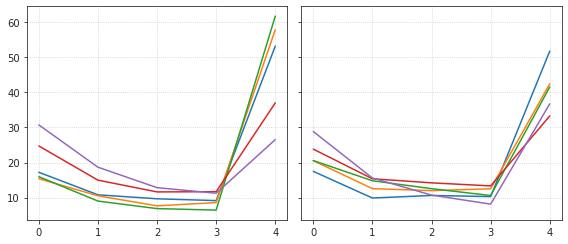

In [22]:
# bins = np.linspace(0.2, 1.0, 5) # np.linspace(0.15, 1.0, 18)
bins = [0.15, 0.30, 0.45, 0.60, 0.75, 1.0]

cutted_ca = cut_data(
    data=gr_ca.run_pi_prune.reshape(-1, 5, 174),
    bins=bins,
    decimals=4,
    oc_only=True,
)[0].reshape(10, 3, 4, 5, len(bins) - 1)
cutted_bold = cut_data(
    data=gr_bold.run_pi_prune.reshape(-1, 5, 174),
    bins=bins,
    decimals=4,
    oc_only=True,
)[0].reshape(10, 3, 4, 5, len(bins) - 1)

cutted_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(cutted_ca, 2), 1), 0)
cutted_bold_avg = bn.nanmean(bn.nanmean(bn.nanmean(cutted_bold, 2), 1), 0)

fig, axes = create_figure(1, 2, (8, 3.5), 'all', 'all')
axes[0].plot(cutted_bold_avg.T)
axes[1].plot(cutted_ca_avg.T)
add_grid(axes)
plt.show()

In [23]:
slope, intercept, r, p, se = sp_stats.linregress(100 - portion_ovp_bold_avg, cutted_bold_avg[:, -1])
slope, intercept, r, p, se

(
    1.0201606951442719,
    3.2949491644975453,
    0.9990314292773548,
    3.617993286195647e-05,
    0.025942049768603804
)

In [24]:
slope, intercept, r, p, se = sp_stats.linregress(100 - portion_ovp_ca_avg, cutted_ca_avg[:, -1])
slope, intercept, r, p, se

(
    0.9483713479099273,
    6.764230872396475,
    0.980452037101275,
    0.003271211108781187,
    0.10988144491573247
)

<AxesSubplot:>

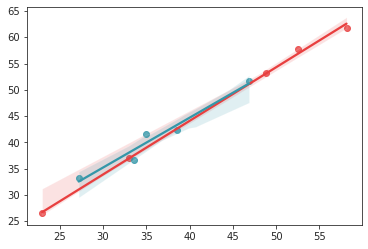

In [25]:
sns.regplot(x=100 - portion_ovp_bold_avg, y=cutted_bold_avg[:, -1], color=pal['bold-lite'])
sns.regplot(x=100 - portion_ovp_ca_avg, y=cutted_ca_avg[:, -1], color=pal['ca2'])

In [26]:
x_bold = 100 - portion_ovp_bold.ravel()
y_bold = cutted_bold[..., -1].ravel()
good_bold = np.logical_and(np.isfinite(x_bold), np.isfinite(y_bold))

slope, intercept, r, p, se = sp_stats.linregress(x_bold[good_bold], y_bold[good_bold])
slope, intercept, r, p, se

(
    0.9844746026424067,
    4.829362643545366,
    0.9784215959435011,
    0.0,
    0.008723151223717739
)

In [27]:
x_ca = 100 - portion_ovp_ca.ravel()
y_ca = cutted_ca[..., -1].ravel()
good_ca = np.logical_and(np.isfinite(x_ca), np.isfinite(y_ca))

slope, intercept, r, p, se = sp_stats.linregress(x_ca[good_ca], y_ca[good_ca])
slope, intercept, r, p, se

(
    0.985717251828234,
    5.401776907635906,
    0.9545875796587282,
    2.073651339363e-311,
    0.01268711297220194
)

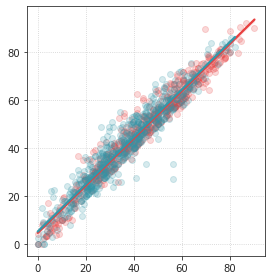

In [28]:
fig, ax = create_figure()
sns.regplot(x=x_bold[good_bold], y=y_bold[good_bold], color=pal['bold-lite'], scatter_kws={'alpha': 0.2}, ax=ax)
sns.regplot(x=x_ca[good_ca], y=y_ca[good_ca], color=pal['ca2'], scatter_kws={'alpha': 0.2}, ax=ax)
ax.set_aspect('equal')
ax.grid()
plt.show()

In [80]:
thres = 0.2
x = gr_ca.run_pi_prune > thres
x.shape

(10, 3, 4, 5, 174)

In [81]:
c_nodes = x.sum(-2).astype(float)
ovp = c_nodes > 1
disj = c_nodes == 1

c_nodes.shape

(10, 3, 4, 174)

In [82]:
ovp_sz_net = np.zeros(gr_ca.run_pi_prune.shape[:-1])
looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    o = ovp[i, j, k]
    d = disj[i, j, k]
    ovp_sz_net[i, j, k] = x[i, j, k][:, o].sum(1)
    ovp_sz_net[i, j, k] *= 100 / (x[i, j, k][:, o].sum(1) + x[i, j, k][:, d].sum(1))

In [83]:
ovp_sz_net.shape

(10, 3, 4, 5)

In [84]:
ovp_sz_net_avg = bn.nanmean(bn.nanmean(bn.nanmean(ovp_sz_net, 2), 1), 0)
np.round(ovp_sz_net_avg, 1)

array([44.2, 51.7, 56.1, 63.4, 57.5])

## Entropy with log(k) / log(5)

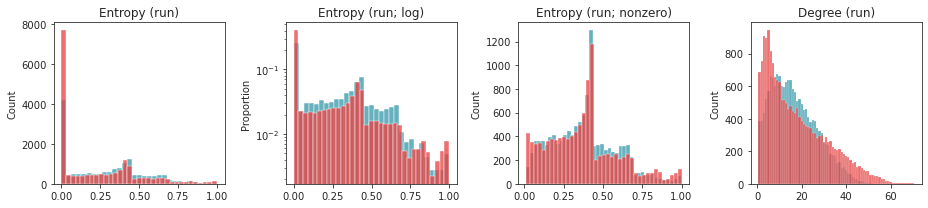

In [86]:
fig, axes = create_figure(1, 4, (13, 3))
sns.histplot(gr_ca.run_h[np.isfinite(gr_ca.run_h)], color=pal['ca2'], ax=axes[0])
sns.histplot(gr_bold.run_h[np.isfinite(gr_bold.run_h)], color=pal['bold-lite'], ax=axes[0])
axes[0].set_title('Entropy (run)')

sns.histplot(gr_ca.run_h[np.isfinite(gr_ca.run_h)], stat='proportion', color=pal['ca2'], ax=axes[1])
sns.histplot(gr_bold.run_h[np.isfinite(gr_bold.run_h)], stat='proportion', color=pal['bold-lite'], ax=axes[1])
axes[1].set_title('Entropy (run; log)')
axes[1].set_yscale('log')

sns.histplot(gr_ca.run_h[gr_ca.run_h.nonzero()], color=pal['ca2'], ax=axes[2])
sns.histplot(gr_bold.run_h[gr_bold.run_h.nonzero()], color=pal['bold-lite'], ax=axes[2])
axes[2].set_title('Entropy (run; nonzero)')

sns.histplot(gr_ca.run_deg[np.isfinite(gr_ca.run_deg)],
             bins=np.linspace(0.5, 70.5, 71), color=pal['ca2'], ax=axes[3])
sns.histplot(gr_bold.run_deg[np.isfinite(gr_bold.run_deg)],
             bins=np.linspace(0.5, 70.5, 71), color=pal['bold-lite'], ax=axes[3])
axes[3].set_title('Degree (run)')

plt.show()

In [87]:
np.log(2) / np.log(5), np.log(3) / np.log(5), np.log(4) / np.log(5)

(0.43067655807339306, 0.6826061944859854, 0.8613531161467861)

In [88]:
(0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)

0.26264392340968856

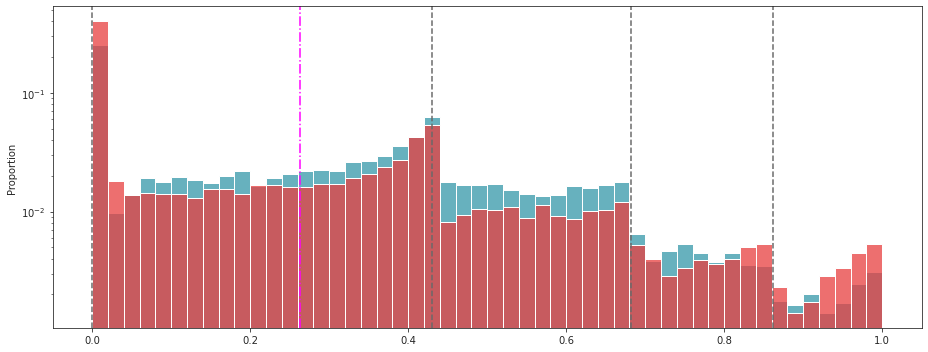

In [89]:
fig, ax = create_figure(figsize=(13, 5))

for i in range(5):
    ax.axvline(np.log(i) / np.log(5), color='dimgrey', ls='--')
    
x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
ax.axvline(x, color='magenta', ls='-.')

sns.histplot(gr_ca.run_h[np.isfinite(gr_ca.run_h)],
             stat='proportion', bins=np.linspace(0.0, 1.0, 51),
             color=pal['ca2'], ax=ax)
sns.histplot(gr_bold.run_h[np.isfinite(gr_bold.run_h)],
             stat='proportion', bins=np.linspace(0.0, 1.0, 51),
             color=pal['bold-lite'], ax=ax)
# ax.set_title('Entropy (run; log)')
ax.set_yscale('log')

In [415]:
num = 100
bins = np.linspace(-1 / num, 1.0, num + 2)
xs = (bins[1:] + bins[:-1]) / 2
xs[0] = 0

In [416]:
i, j, k = gr_bold.run_h.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}


h_bold = cut_data(
    data=gr_bold.run_h.reshape(-1, 1, 174),
    bins=bins,
    oc_only=True,
)[0].reshape(i, j, k, -1)
h_bold_avg = bn.nanmean(bn.nanmean(bn.nanmean(h_bold, 2), 1), 0)

boot = bootstrap(
    x=h_bold,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_bold = bn.nanstd(boot, 0, ddof=1)


h_ca = cut_data(
    data=gr_ca.run_h.reshape(-1, 1, 174),
    bins=bins,
    oc_only=True,
)[0].reshape(i, j, k, -1)
h_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 2), 1), 0)

boot = bootstrap(
    x=h_ca,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

In [417]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)

In [418]:
from matplotlib.pyplot import text as mp_txt

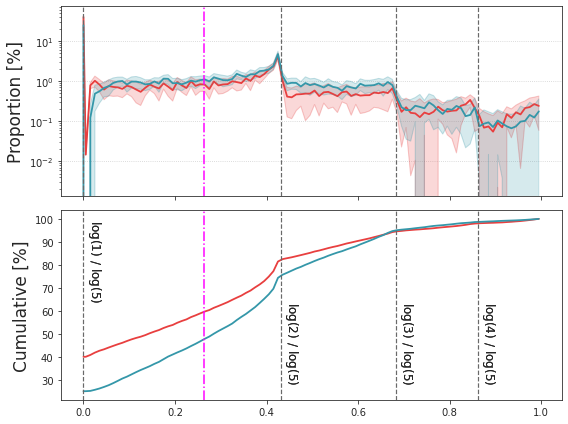

In [419]:
fig, axes = create_figure(2, 1, figsize=(8, 6), sharex='col')

ax = axes[0]
for y, color in zip([h_bold_avg, h_ca_avg], [pal['bold-lite'], pal['ca2']]):
    lo = y - se_ca * t
    hi = y + se_ca * t
    ax.plot(xs, y, color=color, lw=1.8)
    ax.plot(xs, lo, color=color, lw=1., alpha=0.1)
    ax.plot(xs, hi, color=color, lw=1., alpha=0.1)
    ax.fill_between(xs, lo, hi, color=color, alpha=0.2)
ax.set_ylabel('Proportion [%]', fontsize=17)
ax.set_yscale('log')
ax.grid(axis='y')

ax = axes[1]
ax.plot(xs, np.cumsum(h_bold_avg), lw=1.8, color=pal['bold-lite'])
ax.plot(xs, np.cumsum(h_ca_avg), lw=1.8, color=pal['ca2'])
ax.set_ylabel('Cumulative [%]', fontsize=17)

for ax in axes.flat:
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=1.2)
        mp_txt(
            x=x + 0.005,
            y=100 if i == 1 else 64,
            s=f"$\log({i}) \,\,/\,\, \log(5)$",
            fontsize=12,
            rotation=270,
            va='top',
        )

    x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
    ax.axvline(x, color='magenta', ls='-.', lw=1.5)

In [412]:
sp_stats.entropy([0.85] + [0.15 / 4] * 4) / np.log(5)

0.3918468908317064

In [413]:
sp_stats.entropy([0.85] + [0.15]) / np.log(5)

0.26264392340968856

In [348]:
np.concatenate([h_bold_avg.reshape(1, -1), h_ca_avg.reshape(1, -1)]).mean(0)

array([3.25239071e+01, 7.38333451e-03, 4.55953510e-01, 7.57388666e-01,
       6.91508912e-01, 6.49017076e-01, 7.53597611e-01, 8.12316839e-01,
       8.42788590e-01, 8.27340793e-01, 7.98925238e-01, 8.45653259e-01,
       7.99994490e-01, 7.35221304e-01, 7.58445884e-01, 8.42560900e-01,
       8.56921708e-01, 7.64284655e-01, 1.01967561e+00, 9.38929038e-01,
       7.42892562e-01, 9.25568934e-01, 8.10051726e-01, 7.99350957e-01,
       1.01670332e+00, 8.69840428e-01, 9.52052258e-01, 9.64150039e-01,
       8.14159560e-01, 1.11637113e+00, 9.70656947e-01, 9.46581667e-01,
       9.48862611e-01, 1.06332127e+00, 1.23676486e+00, 1.13464306e+00,
       1.22293352e+00, 1.25192642e+00, 1.43737630e+00, 1.52369130e+00,
       1.66909326e+00, 1.95452198e+00, 2.36625195e+00, 4.47710326e+00,
       1.19644474e+00, 6.38044288e-01, 6.54322892e-01, 6.86935158e-01,
       6.07077618e-01, 6.94150209e-01, 6.43517068e-01, 7.18781929e-01,
       6.03213492e-01, 6.12598964e-01, 6.78196514e-01, 6.02035772e-01,
       5.53906204e-01, 5.55666618e-01, 6.52238387e-01, 5.64028656e-01,
       5.67126554e-01, 6.50397447e-01, 6.10566087e-01, 6.16275329e-01,
       6.59633119e-01, 6.93455909e-01, 6.52903881e-01, 7.29418314e-01,
       7.32596856e-01, 3.67265106e-01, 1.98744523e-01, 2.07391386e-01,
       1.76625173e-01, 2.00968278e-01, 1.77867638e-01, 1.88407355e-01,
       2.24040606e-01, 2.10934997e-01, 2.10466093e-01, 1.70601896e-01,
       1.89598476e-01, 1.88291432e-01, 2.14333658e-01, 2.29426828e-01,
       2.00045606e-01, 2.42726893e-01, 2.18670677e-01, 1.06727111e-01,
       7.84333400e-02, 8.42090316e-02, 6.35560896e-02, 9.88523795e-02,
       7.94015993e-02, 1.12924319e-01, 9.42703478e-02, 1.21318557e-01,
       1.23569595e-01, 1.58380922e-01, 1.85244375e-01, 1.96870869e-01,
       2.09619061e-01])

[<matplotlib.lines.Line2D object at 0x7f2f6b745b20>]

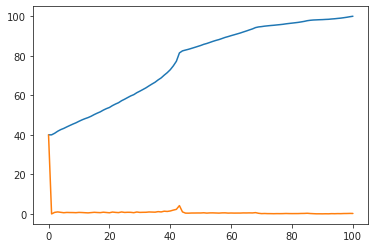

In [351]:
plt.plot(np.cumsum(h_bold_avg))
plt.plot(h_bold_avg)

[<matplotlib.lines.Line2D object at 0x7f2f6baff700>]

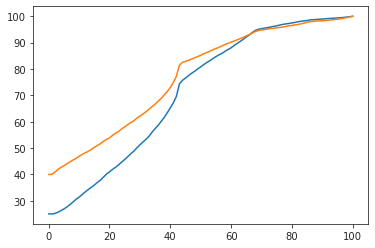

In [352]:
plt.plot(np.cumsum(h_ca_avg))
plt.plot(np.cumsum(h_bold_avg))

[<matplotlib.lines.Line2D object at 0x7f2f6bce05e0>]

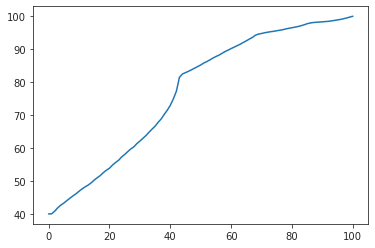

In [107]:
bins

array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,
        0.16,  0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,
        0.34,  0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,
        0.52,  0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,
        0.7 ,  0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,
        0.88,  0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ])

In [301]:
np.log(0)

-inf

In [8]:
len(gr_ca.run_h.flat), len(gr_ca.run_deg.flat)

(20880, 20880)

In [9]:
len(gr_bold.run_h.flat), len(gr_bold.run_deg.flat)

(20880, 20880)

In [10]:
num = len(gr_ca.run_h.flat)

In [11]:
df = pd.DataFrame({
    'mode': ['ca2'] * num + ['bold-lite'] * num,
    'Degree': list(gr_ca.run_deg.flat) + list(gr_bold.run_deg.flat),
    'Entropy': list(gr_ca.run_h.flat) + list(gr_bold.run_h.flat),
})

In [12]:
df

,mode,Degree,Entropy
0,ca2,NaN,NaN
1,ca2,NaN,NaN
2,ca2,NaN,NaN
3,ca2,NaN,NaN
4,ca2,NaN,NaN
...,...,...,...
41755,bold-lite,8.0,0.000000
41756,bold-lite,25.0,0.000000
41757,bold-lite,5.0,0.000000
41758,bold-lite,4.0,0.242585


In [13]:
41760 / num

2.0

<AxesSubplot:xlabel='Entropy', ylabel='Degree'>

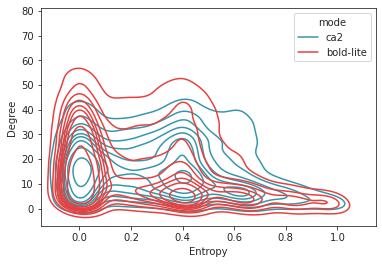

In [14]:
sns.kdeplot(
    data=df,
    x='Entropy',
    y='Degree',
    hue='mode',
    palette=pal,
)

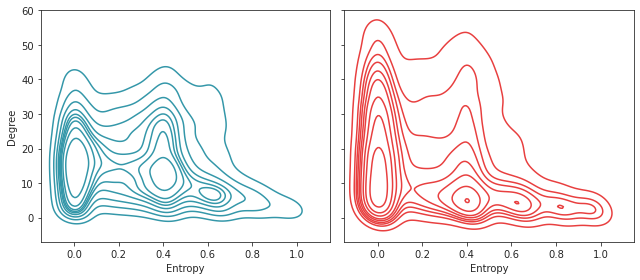

In [15]:
ylim_max = 60

fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ylim = ax.get_ylim()
ax.set_ylim((ylim[0], ylim_max))
plt.show()

### Full df

In [16]:
affil, affil_included = gr_ca.node_affiliations()

In [23]:
dlist = []
looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    if np.isnan(gr_ca.run_h[i, j, k]).sum() < len(gr_ca.n2l):
        dlist.append({
            'mode': ['ca2'] * len(affil_included),
            'subject': [i + 1] * len(affil_included),
            'session': [j + 1] * len(affil_included),
            'run': [k + 1] * len(affil_included),
            'Affiliation': affil_included,
            'Entropy': gr_ca.run_h[i, j, k],
            'Degree': gr_ca.run_deg[i, j, k],
        })
    if np.isnan(gr_bold.run_h[i, j, k]).sum() < len(gr_bold.n2l):
        dlist.append({
            'mode': ['bold-lite'] * len(affil_included),
            'subject': [i + 1] * len(affil_included),
            'session': [j + 1] * len(affil_included),
            'run': [k + 1] * len(affil_included),
            'Affiliation': affil_included,
            'Entropy': gr_bold.run_h[i, j, k],
            'Degree': gr_bold.run_deg[i, j, k],
        })
df = pd.DataFrame(merge_dicts(dlist))
df.shape

(40368, 7)

In [35]:
sp_stats.entropy([0.15, 0.85, 0, 0, 0]) / np.log(5), sp_stats.entropy([0.2, 0.8, 0, 0, 0]) / np.log(5)

(0.26264392340968856, 0.31091750708257115)

In [45]:
vlines = [0.25, 0.52]
hlines = [15]

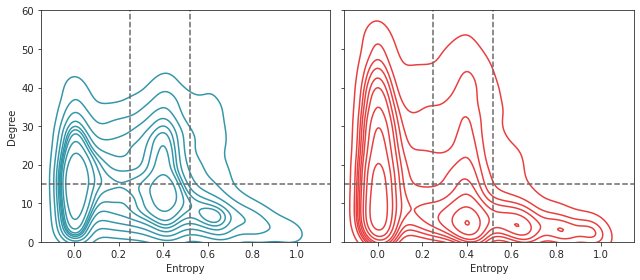

In [46]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--')
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--')
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 60))

plt.show()

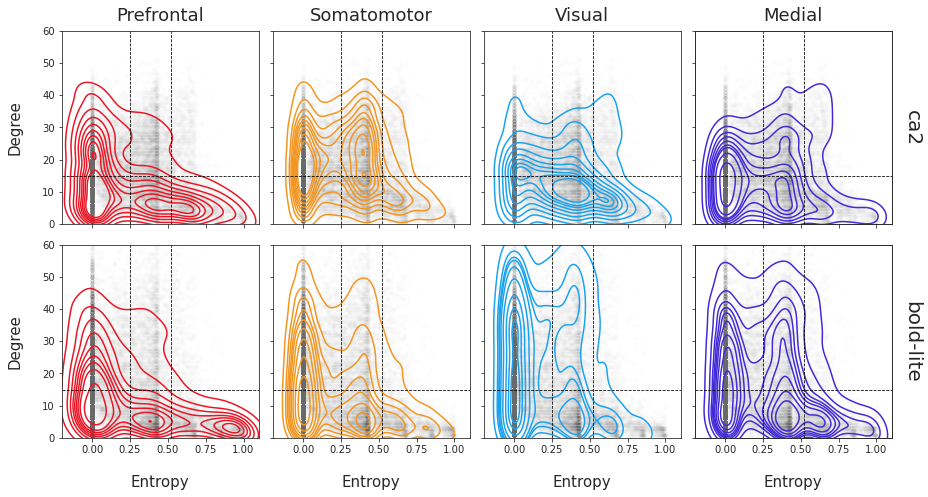

In [47]:
selected = ['Prefrontal', 'Somatomotor', 'Visual', 'Medial']

fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='k', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='k', ls='--', lw=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=20,
            alpha=0.01,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
ax.set_ylim((0, 60))
ax.set_xlim((-0.2, 1.1))

plt.show()

In [48]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 15), (0, 0.25)),
    '01': ((0, 15), (0.25, 0.52)),
    '02': ((0, 15), (0.52, 1)),
    '10': ((15, 100), (0, 0.25)),
    '11': ((15, 100), (0.25, 0.52)),
    '12': ((15, 100), (0.52, 1))
}

In [49]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.run_h, gr_ca.run_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.run_deg, gr_ca.run_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = bn.nanmean(bn.nanmean(bn.nanmean(cond, 2), 1), 0)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)

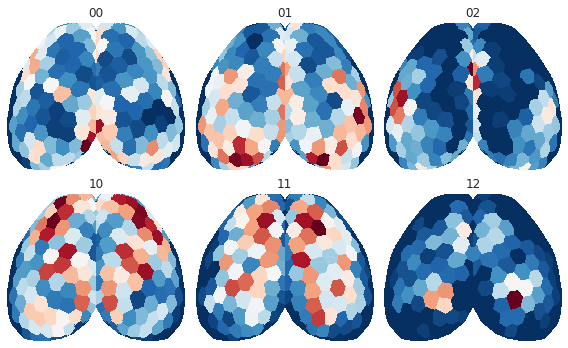

In [50]:
fig, axes = create_figure(2, 3, (8, 5))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='RdBu_r')
    ax.set_title(k)
remove_ticks(axes)

In [51]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_bold.run_h, gr_bold.run_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_bold.run_deg, gr_bold.run_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = bn.nanmean(bn.nanmean(bn.nanmean(cond, 2), 1), 0)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_bold.project_vec(carto_vec, add_disjoint=False)
tr = gr_bold.trim2d(proj)

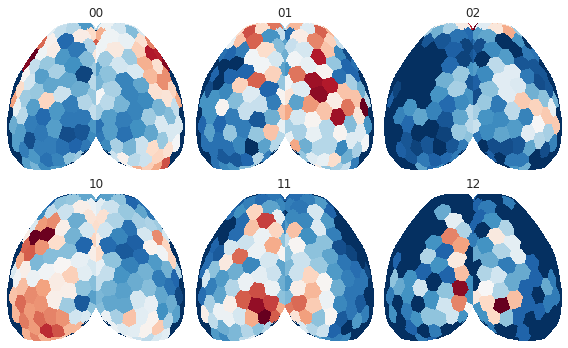

In [52]:
fig, axes = create_figure(2, 3, (8, 5))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='RdBu_r')
    ax.set_title(k)
remove_ticks(axes)

### Animal

In [84]:
gr_ca.anim_deg = bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1)
gr_bold.anim_deg = bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1)

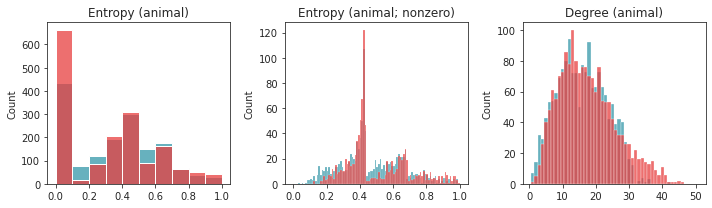

In [85]:
fig, axes = create_figure(1, 3, (10, 3), 'col')
sns.histplot(gr_ca.anim_h[np.isfinite(gr_ca.anim_h)],
             bins=np.linspace(0, 1.0, 11), color=pal['ca2'], ax=axes[0])
sns.histplot(gr_bold.anim_h[np.isfinite(gr_bold.anim_h)],
             bins=np.linspace(0, 1.0, 11), color=pal['bold-lite'], ax=axes[0])
axes[0].set_title('Entropy (animal)')

sns.histplot(gr_ca.anim_h[gr_ca.anim_h.nonzero()],
             bins=np.linspace(0, 1.0, 101), color=pal['ca2'], ax=axes[1])
sns.histplot(gr_bold.anim_h[gr_bold.anim_h.nonzero()],
             bins=np.linspace(0, 1.0, 101), color=pal['bold-lite'], ax=axes[1])
axes[1].set_title('Entropy (animal; nonzero)')

sns.histplot(gr_ca.anim_deg[np.isfinite(gr_ca.anim_deg)],
             bins=np.linspace(0.5, 50.5, 51), color=pal['ca2'], ax=axes[2])
sns.histplot(gr_bold.anim_deg[np.isfinite(gr_bold.anim_deg)],
             bins=np.linspace(0.5, 50.5, 51), color=pal['bold-lite'], ax=axes[2])
axes[2].set_title('Degree (animal)')

plt.show()

In [86]:
x = gr_bold.anim_h[gr_bold.anim_h.nonzero()]
x = x[~np.isnan(x)]
len(x)

1024

In [87]:
bins = np.linspace(0, 1.0, 1001)
bins

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

In [88]:
hist, bin_edges = np.histogram(x, bins=bins)

In [91]:
max_count = np.max(hist)
max_id = np.where(hist == max_count)[0].item()

max_count, max_id

(46, 430)

In [92]:
bins[max_id], bins[max_id + 1]

(0.43, 0.431)

In [93]:
np.log(2) / np.log(5)

0.43067655807339306

In [94]:
cond = np.logical_and(0.430 < gr_bold.anim_h, gr_bold.anim_h < 0.431)
ids = list(zip(*np.where(cond)))

In [95]:
for i, j in ids:
    print(i, j, np.round(gr_bold.anim_pi_prune[i, :, j], 2))

0 2 [0.52 0.   0.48 0.   0.  ]

0 40 [0.5 0.  0.  0.5 0. ]

0 44 [0.  0.  0.5 0.  0.5]

0 45 [0.   0.   0.48 0.   0.52]

0 51 [0.   0.   0.   0.48 0.52]

0 60 [0.   0.48 0.   0.   0.52]

1 65 [0.  0.5 0.  0.5 0. ]

1 77 [0.   0.52 0.   0.   0.48]

1 96 [0.48 0.   0.52 0.   0.  ]

1 109 [0.51 0.   0.49 0.   0.  ]

2 14 [0.49 0.   0.51 0.   0.  ]

2 144 [0.   0.   0.   0.49 0.51]

2 146 [0.   0.   0.   0.49 0.51]

2 159 [0.   0.48 0.   0.   0.52]

3 27 [0.51 0.   0.49 0.   0.  ]

3 60 [0.  0.5 0.  0.  0.5]

3 98 [0.5 0.  0.5 0.  0. ]

3 121 [0.49 0.   0.   0.51 0.  ]

3 159 [0.   0.52 0.   0.   0.48]

4 20 [0.49 0.   0.51 0.   0.  ]

4 45 [0.   0.   0.49 0.   0.51]

4 54 [0.  0.5 0.  0.  0.5]

4 59 [0.   0.52 0.   0.   0.48]

4 60 [0.   0.48 0.   0.   0.52]

4 76 [0.  0.5 0.  0.  0.5]

4 143 [0.  0.  0.  0.5 0.5]

4 144 [0.  0.5 0.  0.5 0. ]

5 22 [0.   0.   0.52 0.   0.48]

6 20 [0.52 0.   0.48 0.   0.  ]

6 132 [0.  0.  0.  0.5 0.5]

6 134 [0.  0.  0.  0.5 0.5]

6 142 [0.48 0.   0.   0.   0.52]

6 146 [0.  0.5 0.  0.  0.5]

6 147 [0.   0.51 0.   0.   0.49]

6 149 [0.   0.49 0.   0.   0.51]

7 57 [0.   0.48 0.   0.52 0.  ]

7 64 [0.   0.49 0.   0.51 0.  ]

7 96 [0.5 0.  0.5 0.  0. ]

7 136 [0.   0.   0.   0.52 0.48]

7 139 [0.   0.52 0.   0.48 0.  ]

8 47 [0.  0.  0.  0.5 0.5]

8 71 [0.   0.49 0.   0.   0.51]

8 145 [0.   0.51 0.   0.49 0.  ]

8 158 [0.   0.48 0.   0.   0.52]

9 44 [0.   0.   0.49 0.51 0.  ]

9 109 [0.52 0.   0.48 0.   0.  ]

In [96]:
affil, affil_included = gr_ca.node_affiliations()

In [97]:
dlist = []
for i in range(10):
    dlist.append({
        'mode': ['ca2'] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_ca.anim_h[i],
        'Degree': gr_ca.anim_deg[i],
    })
    dlist.append({
        'mode': ['bold-lite'] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_bold.anim_h[i],
        'Degree': gr_bold.anim_deg[i],
    })
df = pd.DataFrame(merge_dicts(dlist))

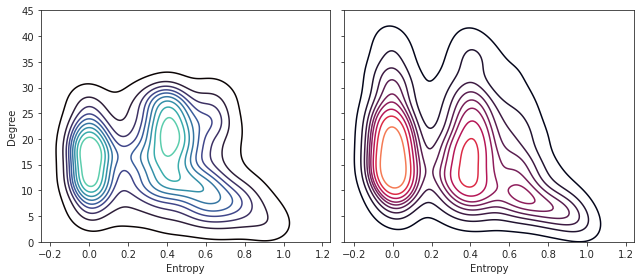

In [98]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        cmap='mako' if mode == 'ca2' else 'rocket',
        #color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))
plt.show()

In [163]:
vlines = [0.19, 0.86]
hlines = [16]

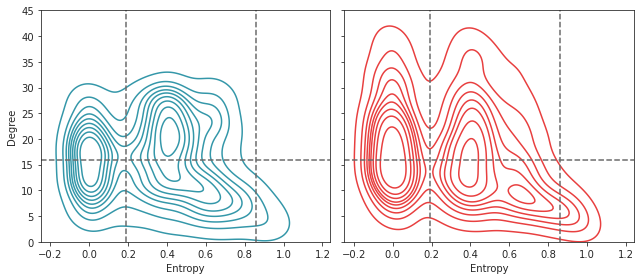

In [164]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--')
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--')
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))

plt.show()

In [165]:
selected = ['Prefrontal', 'Somatomotor', 'Visual', 'Medial']

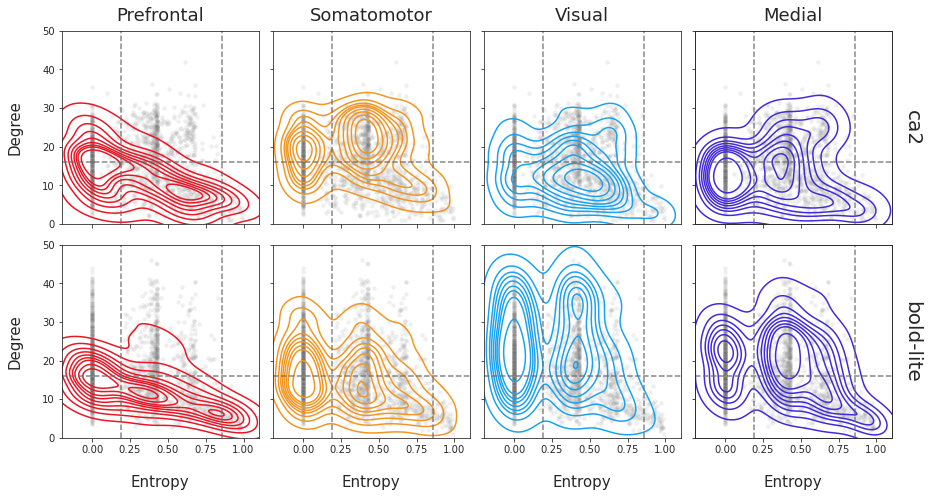

In [166]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', alpha=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', alpha=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=20,
            alpha=0.1,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
ax.set_ylim((0, 50))
ax.set_xlim((-0.2, 1.1))

plt.show()

In [167]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

vedges, hedges

([0, 0.19, 0.86, 1], [0, 16, 100])

In [168]:
coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 16), (0, 0.19)),
    '01': ((0, 16), (0.19, 0.86)),
    '02': ((0, 16), (0.86, 1)),
    '10': ((16, 100), (0, 0.19)),
    '11': ((16, 100), (0.19, 0.86)),
    '12': ((16, 100), (0.86, 1))
}

In [169]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.anim_h, gr_ca.anim_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.anim_deg, gr_ca.anim_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = bn.nanmean(cond, 0)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)

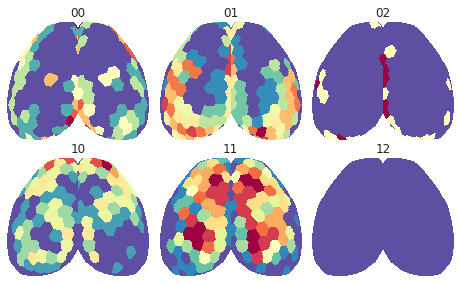

In [173]:
fig, axes = create_figure(2, 3, (6.5, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='Spectral_r')
    ax.set_title(k)
remove_ticks(axes)

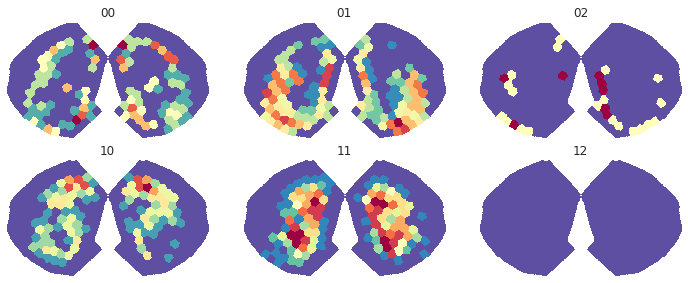

In [174]:
fig, axes = create_figure(2, 3, (10, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['flat'] == 0, tr['proj-flat'][i])
    ax.imshow(x2p, cmap='Spectral_r')
    ax.set_title(k)
remove_ticks(axes)

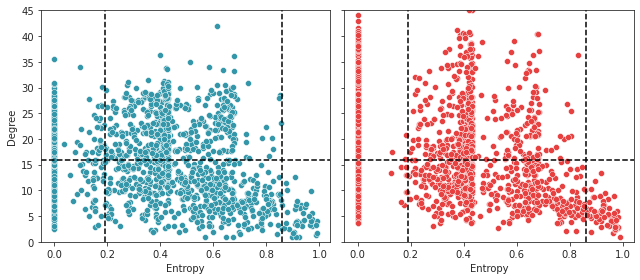

In [175]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='k', ls='--')
    for y in hlines:
        ax.axhline(y, color='k', ls='--')
    sns.scatterplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))

plt.show()

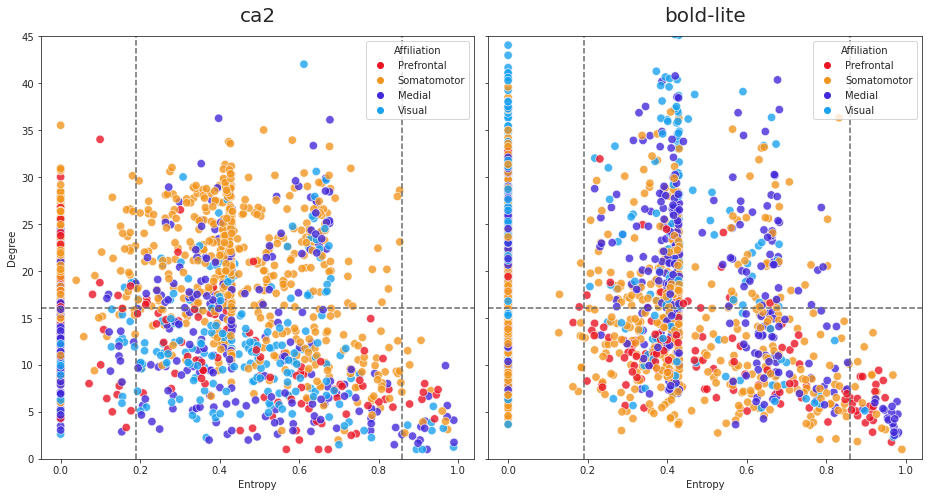

In [176]:
fig, axes = create_figure(1, 2, (13, 7), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--')
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--')
        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=70,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(mode, fontsize=20, y=1.02)
ax.set_ylim((0, 45))

plt.show()

### Group

In [53]:
num = len(gr_ca.grp_h.flat)
gr_ca.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1), 0)
gr_bold.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1), 0)

In [56]:
df = pd.DataFrame({
    'mode': ['ca2'] * num + ['bold-lite'] * num,
    'Degree': list(gr_ca.grp_deg.flat) + list(gr_bold.grp_deg.flat),
    'Entropy': list(gr_ca.grp_h.flat) + list(gr_bold.grp_h.flat),
    'Affiliation': affil_included * 2,
})

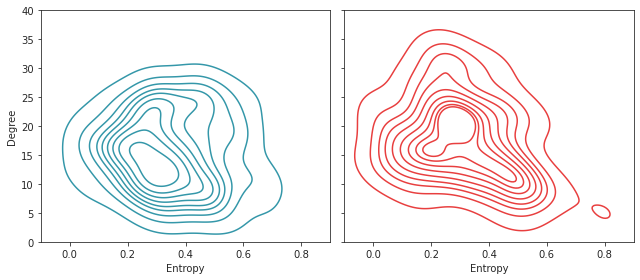

In [57]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        # cmap='mako' if mode == 'ca2' else 'rocket',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))
plt.show()

In [76]:
vlines = [0.25, 0.43]
hlines = [18]

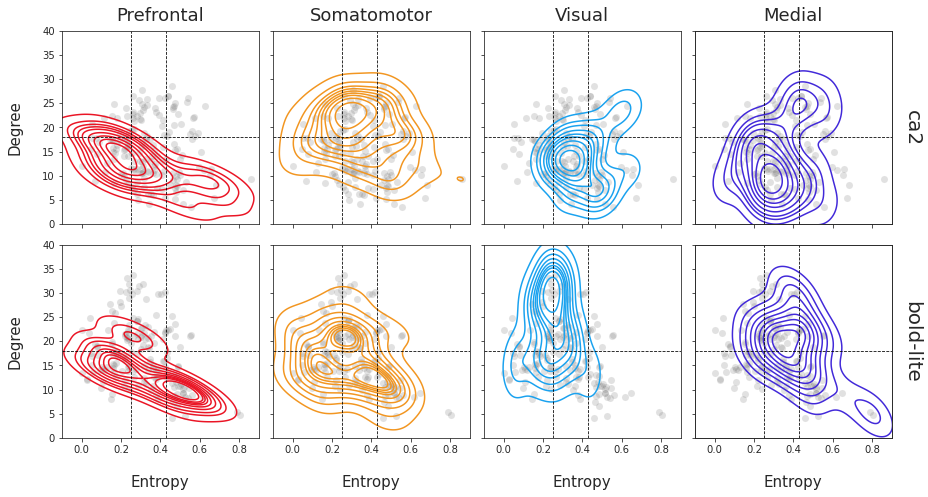

In [77]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='k', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='k', ls='--', lw=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=50,
            alpha=0.2,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
            # axtw.yaxis.set_label_position("right")
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))

plt.show()

In [78]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 18), (0, 0.25)),
    '01': ((0, 18), (0.25, 0.43)),
    '02': ((0, 18), (0.43, 1)),
    '10': ((18, 100), (0, 0.25)),
    '11': ((18, 100), (0.25, 0.43)),
    '12': ((18, 100), (0.43, 1))
}

In [81]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.grp_h, gr_ca.grp_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.grp_deg, gr_ca.grp_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = cond.astype(float)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)

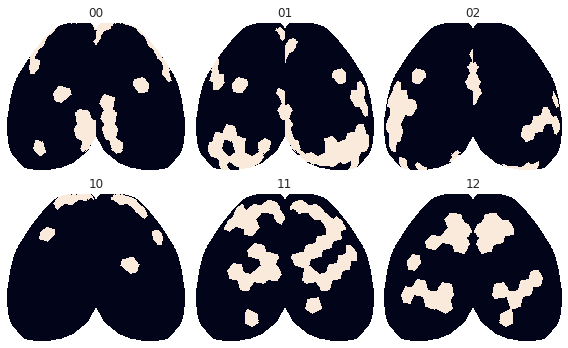

In [83]:
fig, axes = create_figure(2, 3, (8, 5))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='rocket')
    ax.set_title(k)
remove_ticks(axes)